# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
from keras import models
from keras.applications.mobilenet import MobileNet,preprocess_input
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,Callback
from keras.layers import Conv2D,Reshape
from keras.backend import epsilon
import tensorflow as tf
np.random.seed(1)
from csv import reader
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Change directory

In [ ]:
pwd

'/content'

In [ ]:
os.chdir("/content/drive/My Drive/LAB")

### Load the training data from train.csv file

In [ ]:
df=pd.read_csv("train_labels.csv")

In [ ]:
df.shape

(173, 8)

### Print the shape of the train dataset

In [ ]:
df.shape

(173, 8)

In [ ]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [ ]:
IMAGE_SIZE = 128 

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [ ]:
import csv
with open('train_labels.csv','r') as csvfile:
  paths=[]
  coords=np.zeros((sum(1 for line in csvfile) -1,4))
  spamreader=csv.reader(csvfile,delimiter=',')
  csvfile.seek(0)
  next(spamreader,None)
  for i,row in enumerate(spamreader):
    for j,r in enumerate(row):
      if((j!=0) & (j!=3)):
        row[j]=int(r)
    path,width,height,class_,xmin,ymin,xmax,ymax=row
    paths.append(path)

    coords[i,0]=xmin * IMAGE_SIZE/width
    coords[i,1]= ymin * IMAGE_SIZE/height   
    coords[i,2]= xmax * IMAGE_SIZE/width 
    coords[i,3]= ymax * IMAGE_SIZE/height
print(coords) 

[[4.69498069e+01 3.95876289e+01 8.25328185e+01 7.78556701e+01]
 [5.81818182e-01 2.96296296e-01 8.94060606e+01 1.27703704e+02]
 [1.57866667e+01 3.42400000e+01 5.97333333e+01 9.28000000e+01]
 [4.84266667e+01 2.97600000e+01 8.59733333e+01 9.53600000e+01]
 [2.71941392e+01 2.28324324e+01 9.23663004e+01 8.78702703e+01]
 [7.49268293e+00 5.72357724e+00 1.17385366e+02 1.24878049e+02]
 [2.53866667e+01 6.72000000e+00 7.85066667e+01 1.27680000e+02]
 [5.24750958e+01 6.63212435e+00 1.22114943e+02 1.10093264e+02]
 [5.14056225e-01 6.33663366e-01 7.91646586e+01 1.11524752e+02]
 [4.29961390e+01 5.27835052e+00 8.99459459e+01 5.87216495e+01]
 [1.30957096e+01 4.62650602e+00 8.32211221e+01 1.25686747e+02]
 [8.40154440e+00 2.57319588e+01 1.18115830e+02 9.69896907e+01]
 [4.35200000e+00 3.12320000e+01 7.14240000e+01 1.27744000e+02]
 [6.83333333e+00 6.66666667e-01 1.13833333e+02 1.22266667e+02]
 [1.19322034e+01 5.70700637e+00 1.17152542e+02 1.25554140e+02]
 [2.40000000e+01 3.01176471e-01 1.13600000e+02 1.280000

In [ ]:
len(coords)

173

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [ ]:
pwd

'/content/drive/My Drive/LAB'

In [ ]:
from PIL import Image
batch_images=np.zeros((len(paths),IMAGE_SIZE,IMAGE_SIZE,3), dtype=np.float32)

for i,f in enumerate(paths):
  img=Image.open('/content/drive/My Drive/LAB/images/images/'+ f)
  img=img.resize((IMAGE_SIZE,IMAGE_SIZE))
  img=img.convert("RGB")
  batch_images[i]=preprocess_input(np.array(img,dtype=np.float32))
  
  

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [ ]:
ALPHA=1.0
from keras import Model

In [ ]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [ ]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [ ]:
PATIENCE=10

In [ ]:
import tensorflow.compat.v1 as tf


In [ ]:
gt=coords

model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates

reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,
            epochs=10,batch_size = 32,
            verbose=1)

Epoch 1/10
6/6 [==============================] - 2s 310ms/step - loss: 3982.6614 - IoU: 0.0870
Epoch 2/10
6/6 [==============================] - 2s 314ms/step - loss: 751.0896 - IoU: 0.4300
Epoch 3/10
6/6 [==============================] - 2s 313ms/step - loss: 482.5220 - IoU: 0.5686
Epoch 4/10
6/6 [==============================] - 2s 310ms/step - loss: 608.5266 - IoU: 0.5424
Epoch 5/10
6/6 [==============================] - 2s 314ms/step - loss: 326.8789 - IoU: 0.6255
Epoch 6/10
6/6 [==============================] - 2s 312ms/step - loss: 198.7577 - IoU: 0.6661
Epoch 7/10
6/6 [==============================] - 2s 314ms/step - loss: 203.1104 - IoU: 0.6354
Epoch 8/10
6/6 [==============================] - 2s 316ms/step - loss: 157.8246 - IoU: 0.7072
Epoch 9/10
6/6 [==============================] - 2s 313ms/step - loss: 124.7745 - IoU: 0.7413
Epoch 10/10
6/6 [==============================] - 2s 310ms/step - loss: 115.3731 - IoU: 0.7513


### Pick a test image from the given data

In [ ]:
import cv2
filename = '/content/drive/My Drive/LAB/images/raccoon-106.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [ ]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [ ]:
region = model.predict(x=np.array([feat_scaled]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

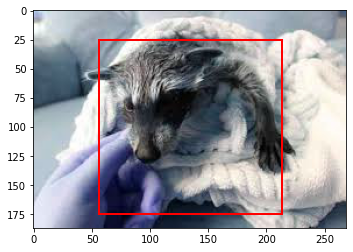

In [ ]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()